In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import json
import h5py
import os
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    import cv2
except:
    pass

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
                            BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pickle

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns


from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
all_images_list = []
for i in os.listdir('stuart_contrib/album_images_(cleaned)'):
    im = cv2.imread('stuart_contrib/album_images_(cleaned)'+'/'+i)
    all_images_list.append(np.array(im)/255.)
all_images_list = np.array(all_images_list)

print('All images now imported.')
print(all_images_list.shape)

All images now imported.
(10156, 128, 128, 3)


# Straight Autoencoder

In [3]:
def get_autoencoder():
    input_img = Input(shape=(128, 128, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    x = Conv2D(16, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [4]:
batch_size = 32
num_classes = 10
epochs = 10
x_train = all_images_list

autoencoder = get_autoencoder()
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/10
10156/10156 [==============================] - 31s 3ms/step - loss: 0.4964
Epoch 2/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4647
Epoch 3/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4531
Epoch 4/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4477
Epoch 5/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4443
Epoch 6/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4421
Epoch 7/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4406
Epoch 8/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4393
Epoch 9/10
10156/10156 [==============================] - 26s 3ms/step - loss: 0.4383
Epoch 10/10
10156/10156 [==============================] - 27s 3ms/step - loss: 0.4373


In [19]:
autoencoder.save('records_ae_v1.h5')

# Variational Autoencoder

In [6]:
def sampling(args):
     """Reparameterization trick by sampling fr an isotropic unit Gaussian.
     # Arguments:
         args (tensor): mean and log of variance of Q(z|X)
     # Returns:
         z (tensor): sampled latent vector
     """

     z_mean, z_log_var = args
     batch = K.shape(z_mean)[0]
     dim = K.int_shape(z_mean)[1]
     # by default, random_normal has mean=0 and std=1.0
     epsilon = K.random_normal(shape=(batch, dim))
     return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [43]:
image_size = 128
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 50
epochs = 400

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 64)   18496       conv2d_18[0][0]                  
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 65536)        0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
dense_10 (

In [44]:
vae.compile(optimizer='rmsprop',loss='binary_crossentropy')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1069684   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       3398595   
Total params: 4,468,279
Trainable params: 4,468,279
Non-trainable params: 0
_________________________________________________________________


In [45]:
vae.fit(x_train,x_train,epochs=400)

Epoch 1/400
10156/10156 [==============================] - 20s 2ms/step - loss: 0.6144
Epoch 2/400
10156/10156 [==============================] - 19s 2ms/step - loss: 0.5591
Epoch 3/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5459
Epoch 4/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5397
Epoch 5/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5381
Epoch 6/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5367
Epoch 7/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5360
Epoch 8/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5353
Epoch 9/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5346
Epoch 10/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5342
Epoch 11/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5337
Epoch 12/400
10156/10156 [===============

10156/10156 [==============================] - 18s 2ms/step - loss: 0.5210
Epoch 94/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5208
Epoch 95/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5208
Epoch 96/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5207
Epoch 97/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5206
Epoch 98/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5205
Epoch 99/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5204
Epoch 100/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5204
Epoch 101/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5203
Epoch 102/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5203
Epoch 103/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5201
Epoch 104/400
10156/10156 [==============

10156/10156 [==============================] - 18s 2ms/step - loss: 0.5164
Epoch 185/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5164
Epoch 186/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5163
Epoch 187/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5163
Epoch 188/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5163
Epoch 189/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5162
Epoch 190/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5162
Epoch 191/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5162
Epoch 192/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5162
Epoch 193/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5162
Epoch 194/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5161
Epoch 195/400
10156/10156 [========

10156/10156 [==============================] - 17s 2ms/step - loss: 0.5142
Epoch 277/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5142
Epoch 278/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5142
Epoch 279/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5141
Epoch 280/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5142
Epoch 281/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5141
Epoch 282/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5142
Epoch 283/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5141
Epoch 284/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5141
Epoch 285/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5141
Epoch 286/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5140
Epoch 287/400
10156/10156 [========

10156/10156 [==============================] - 18s 2ms/step - loss: 0.5130
Epoch 369/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5130
Epoch 370/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5129
Epoch 371/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5130
Epoch 372/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5130
Epoch 373/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5129
Epoch 374/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5129
Epoch 375/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5129
Epoch 376/400
10156/10156 [==============================] - 17s 2ms/step - loss: 0.5129
Epoch 377/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5129
Epoch 378/400
10156/10156 [==============================] - 18s 2ms/step - loss: 0.5129
Epoch 379/400
10156/10156 [========

In [46]:
vae.save('records_vae_v1.h5')
encoder.save('records_encoder_v1.h5')
decoder.save('records_decoder_v1.h5')

# Investigate our results...

In [47]:
vae = load_model('records_vae_v1.h5')
ae = load_model('records_ae_v1.h5')

(128, 128, 3)
(10, 128, 128, 3)
   Original ===  AE ===  VAE


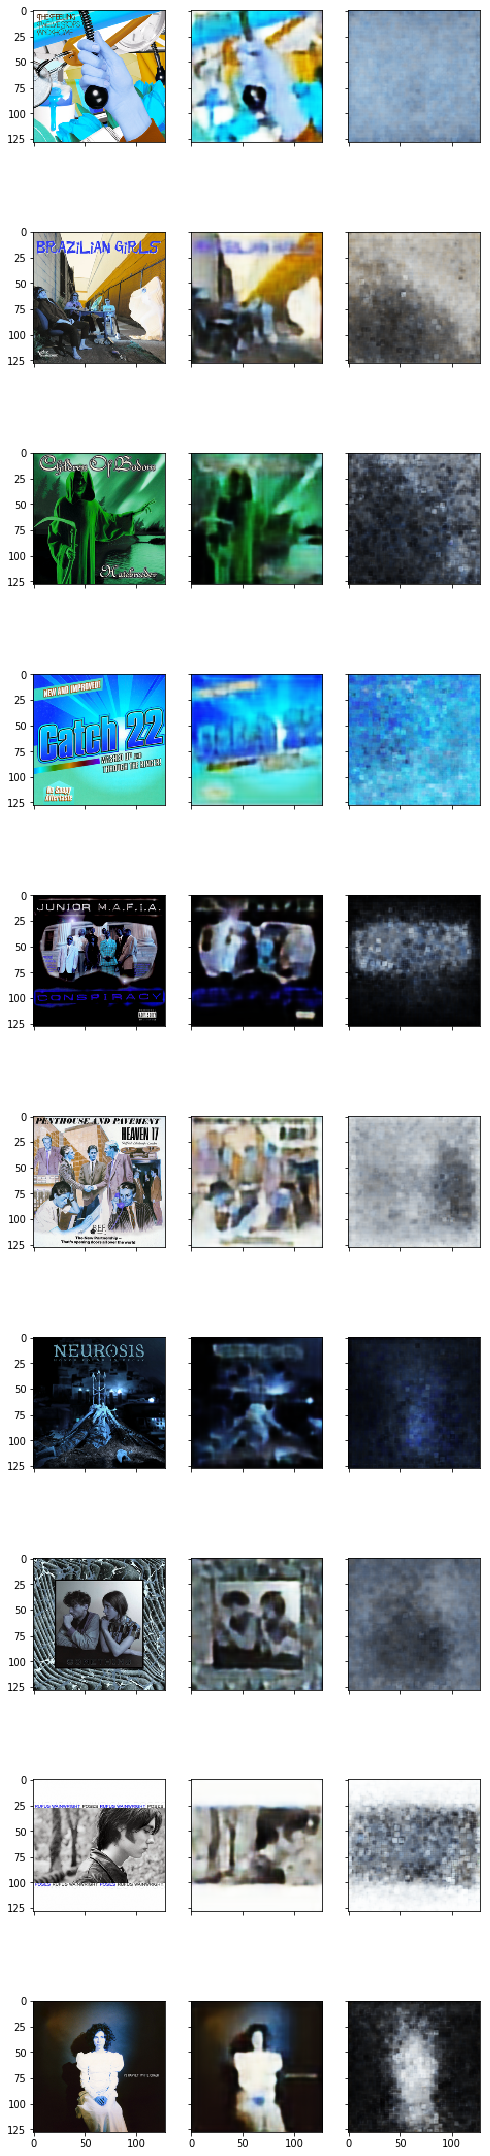

In [48]:
from skimage.io import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 10
start_index = 5000
end_index = start_index + n_samples

pred_set = np.array([x_train[i] for i in range(start_index,start_index+n_samples)])
#pred_set = x_train[start_index:start_index+end_index,:,:,:]
out_vae = vae.predict(pred_set)
out_ae = ae.predict(pred_set)

print(x_train[0].shape)
print(pred_set.shape)
fig_size = (8,40)
print("   Original ===  AE ===  VAE")

f, axarr = plt.subplots(end_index-start_index, 3, figsize=fig_size)

for i in range(n_samples):
    axarr[i,0].imshow(pred_set[i])
    axarr[i,1].imshow(out_ae[i])
    axarr[i,2].imshow(out_vae[i])
    for ax in axarr.flat:
        ax.label_outer()
plt.show()